In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

data = h5py.File('/home/max/Documents/output_32x32/samples.h5', 'r')
print(len(data.keys()))
print(data["step_00000"].keys())

2000
<KeysViewHDF5 ['Eo', 'Ev', 'abs_mag', 'abs_mag_var', 'mag', 'mag_var', 'sample', 'sq_mag', 'sq_mag_var', 'stag_mag', 'stag_mag_var', 'time']>


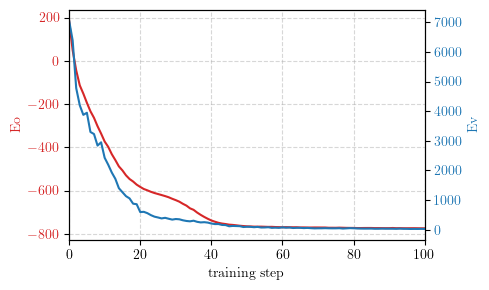

In [2]:
# use latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Eo = np.array([data[f"step_{str(i).zfill(5)}"]['Eo'][()] for i in range(len(data.keys()))])
Ev = np.array([data[f"step_{str(i).zfill(5)}"]['Ev'][()] for i in range(len(data.keys()))])

fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:red'
ax1.set_xlabel('training step')
ax1.set_ylabel('Eo', color=color)
ax1.plot(Eo, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Ev', color=color)  # we already handled the x-label with ax1
ax2.plot(Ev, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.xlim(0,100)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(linestyle='--', alpha=0.5)
plt.savefig('energy_plot_32x32.png', dpi=300, bbox_inches='tight')
plt.show()

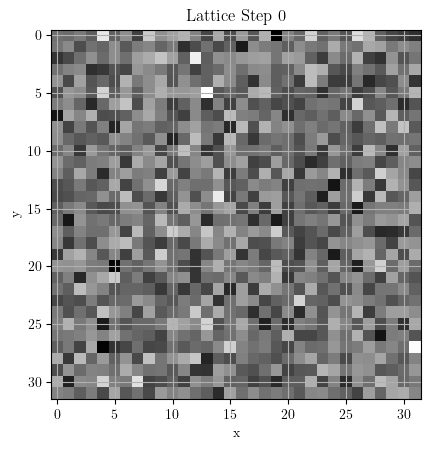

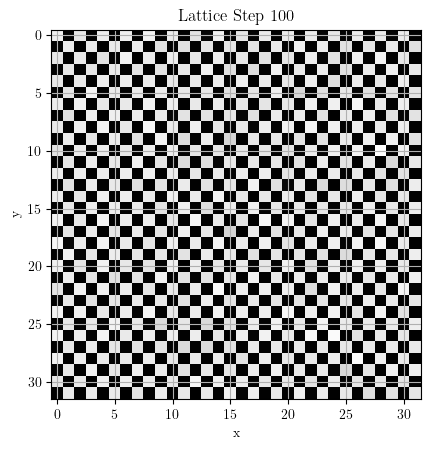

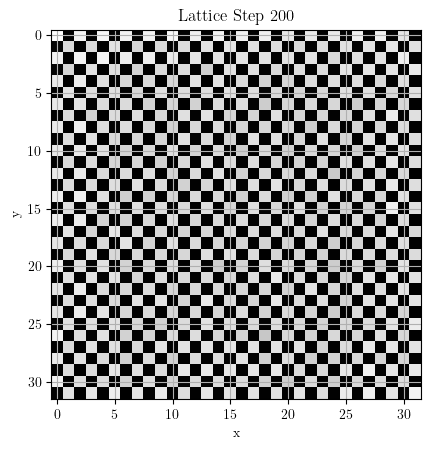

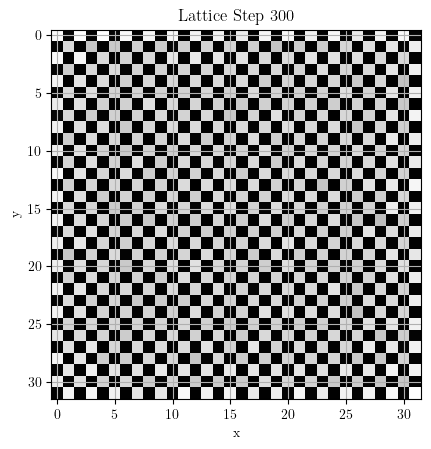

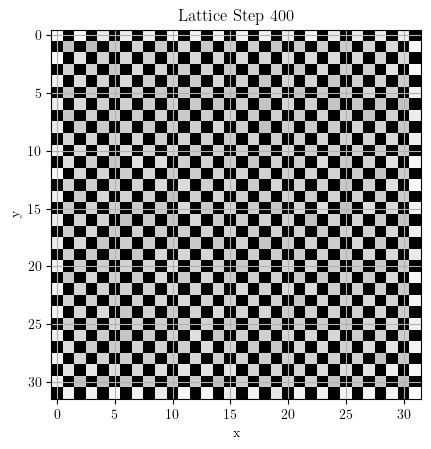

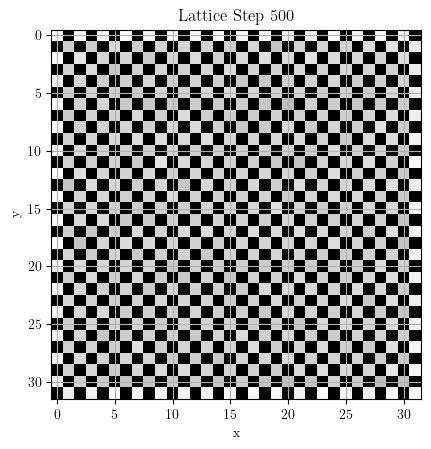

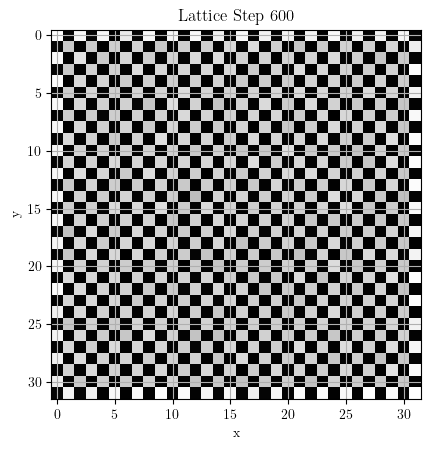

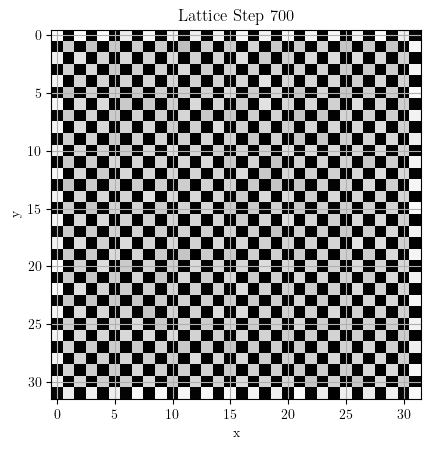

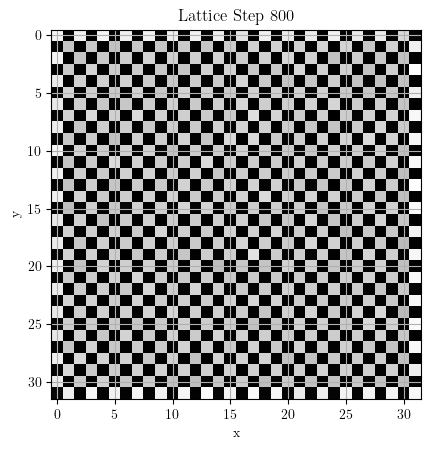

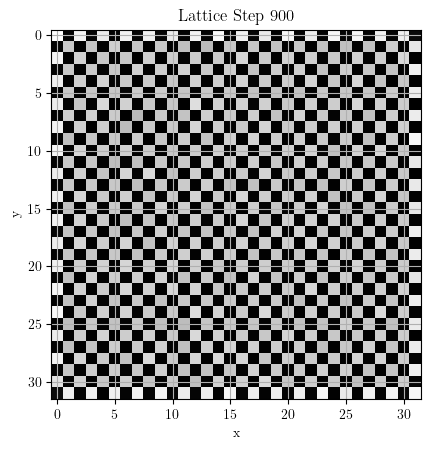

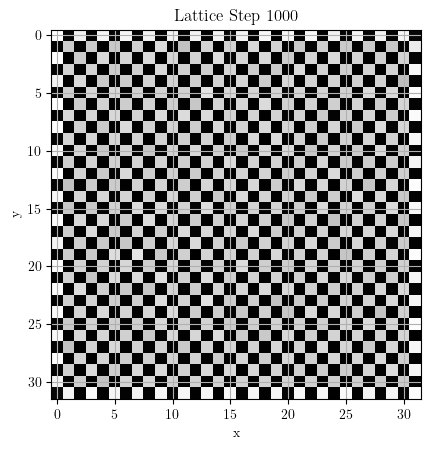

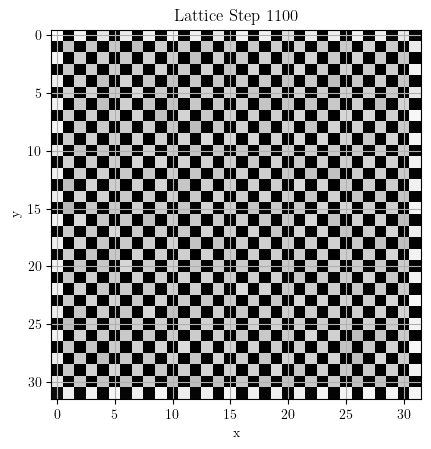

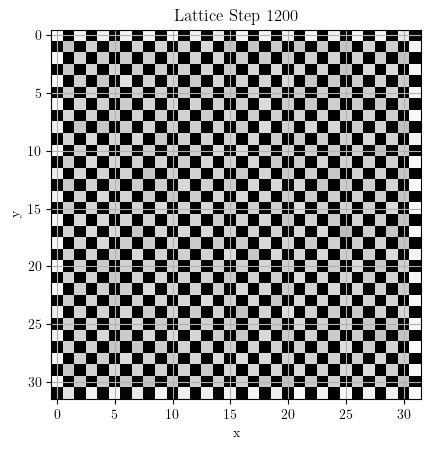

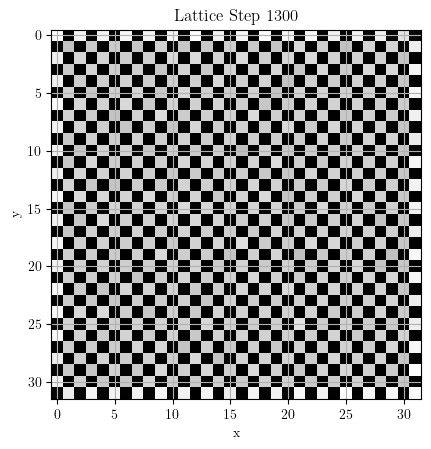

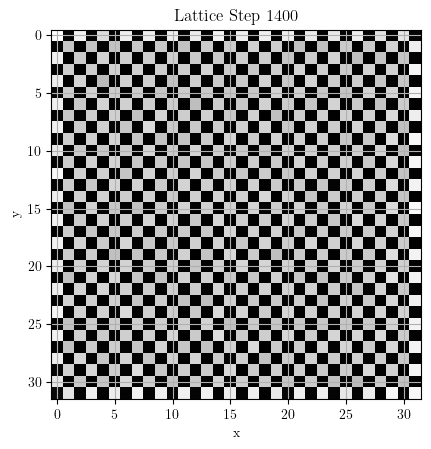

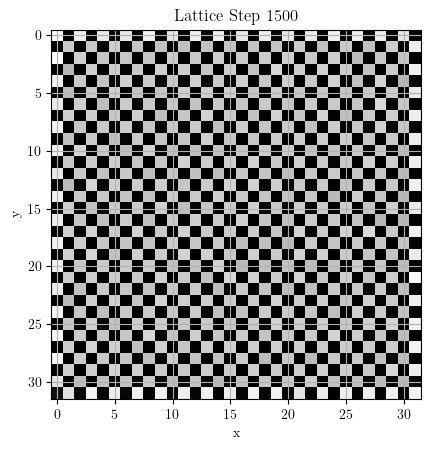

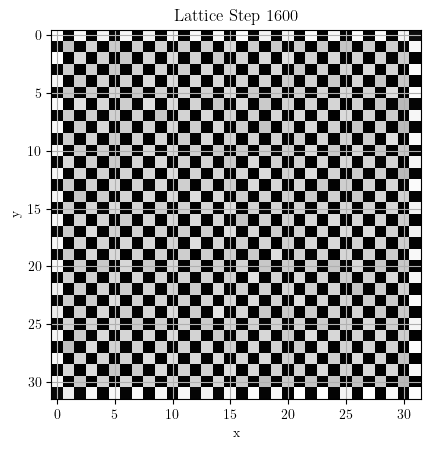

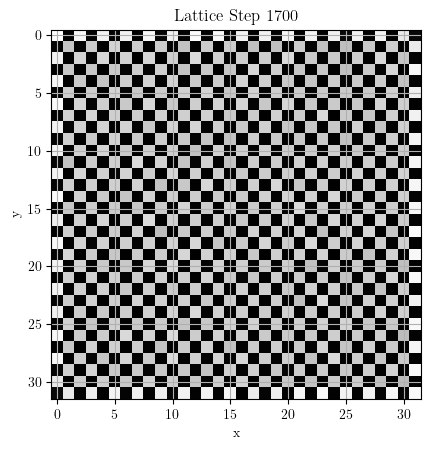

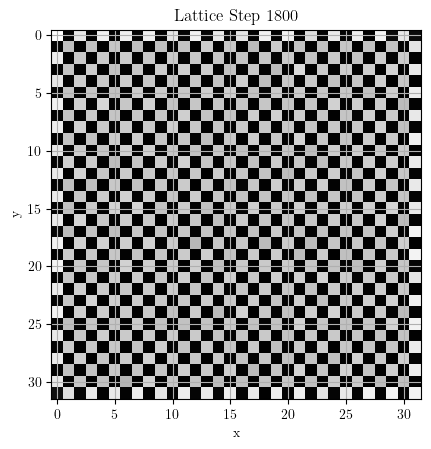

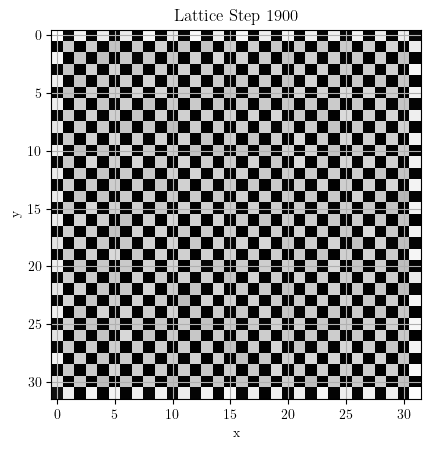

In [3]:
every = 100
for step in range(len(data.keys()))[::every]:
    # Average over the batch dimension and reshape to square lattice
    samples_avg = np.mean(np.array(data[f"step_{step:05d}"]["sample"]), axis=0).reshape(32,32, order="C")
    # samples_avg = np.array(data[f"step_{step:05d}"]["sample"])[0].reshape(12, 12, order="C")
    # Plot the average lattice
    plt.imshow(samples_avg, cmap='gray')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Lattice Step {step}")
    plt.grid()
    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Example: 10000 samples, each is a 2D spin configuration (e.g., 8x8 lattice)
# Each entry is 0 (ground) or 1 (Rydberg excitation)
L = 32
print(data[f"step_{0:05d}"]["sample"].shape)
samples = np.array([np.array(data[f"step_{step:05d}"]["sample"]).reshape(512,L, L, order="C") for step in range(1, len(data.keys()))]).reshape(-1,L, L)
n_samples = len(samples)

(512, 1024, 1)


Coefficients of the polynomial fit: [ 1.92012631e+10 -7.95994635e+10  1.45332004e+11 -1.54177086e+11
  1.05384896e+11 -4.85461273e+10  1.52757401e+10 -3.24441536e+09
  4.45415537e+08 -3.57145690e+07  1.27086894e+06]
Coefficients of the polynomial fit 182.72x^2 + -1740.76x^4 + 4702.92x^6


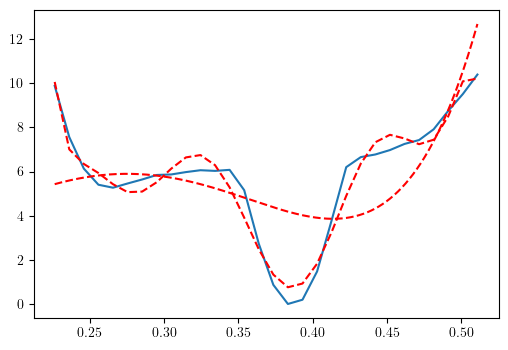

In [5]:
import scipy
def staggered_density(config):
    Lx, Ly = config.shape
    checkerboard = np.fromfunction(lambda i, j: (-1)**(i + j), (Lx, Ly))
    return np.sum(config * checkerboard) / (Lx * Ly)

# Compute order parameter for each sample
phi_vals = np.array([staggered_density(sample) for sample in samples])
phi_vals = np.mean(samples.reshape(n_samples, -1), axis=1)

# Histogram P(φ)
bins = 30
hist, bin_edges = np.histogram(phi_vals, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Compute effective potential V_eff(φ) = -log P(φ)
V_eff = -np.log(hist + 1e-12)  # Add epsilon to avoid log(0)
V_eff -= np.min(V_eff)         # Normalize so minimum is at 0

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, V_eff, label='Effective potential')

def potential(phi,a,b,c):
    return a*phi**2 + b*phi**4 + c*phi**6


popt, pcov = scipy.optimize.curve_fit(potential, bin_centers, V_eff, p0=[1, 1, 1])
a, b, c = popt

coeffs = np.polyfit(bin_centers, V_eff, 10)
print(f"Coefficients of the polynomial fit: {coeffs}")
p = np.poly1d(coeffs)
plt.plot(bin_centers, p(bin_centers), 'r--', label='Polynomial fit')

x_fit = np.linspace(bin_centers[0], bin_centers[-1], 1000)
y_fit = potential(x_fit, a, b, c)
plt.plot(x_fit, y_fit, 'r--', label='Polynomial fit')
print(f"Coefficients of the polynomial fit {a:.2f}x^2 + {b:.2f}x^4 + {c:.2f}x^6")

In [7]:
plt.hist(phi_vals, bins=50)

(array([1.00000e+01, 2.60000e+01, 1.08000e+02, 3.03000e+02, 6.28000e+02,
        9.49000e+02, 1.21400e+03, 1.23000e+03, 1.10500e+03, 9.57000e+02,
        8.46000e+02, 7.87000e+02, 7.00000e+02, 6.52000e+02, 6.50000e+02,
        5.95000e+02, 5.80000e+02, 5.53000e+02, 5.78000e+02, 5.48000e+02,
        5.19000e+02, 5.98000e+02, 1.16800e+03, 4.82600e+03, 2.16050e+04,
        7.02620e+04, 1.58562e+05, 2.41594e+05, 2.45749e+05, 1.63941e+05,
        7.26670e+04, 2.12280e+04, 4.45300e+03, 8.78000e+02, 3.42000e+02,
        2.92000e+02, 3.12000e+02, 2.79000e+02, 2.28000e+02, 2.09000e+02,
        1.68000e+02, 1.66000e+02, 1.34000e+02, 1.20000e+02, 6.60000e+01,
        4.80000e+01, 2.10000e+01, 1.90000e+01, 5.00000e+00, 1.00000e+01]),
 array([0.22167969, 0.22755859, 0.2334375 , 0.23931641, 0.24519531,
        0.25107422, 0.25695313, 0.26283203, 0.26871094, 0.27458984,
        0.28046875, 0.28634766, 0.29222656, 0.29810547, 0.30398437,
        0.30986328, 0.31574219, 0.32162109, 0.3275    , 0.333378

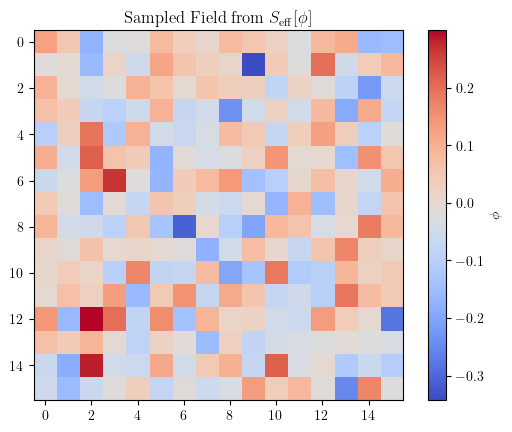

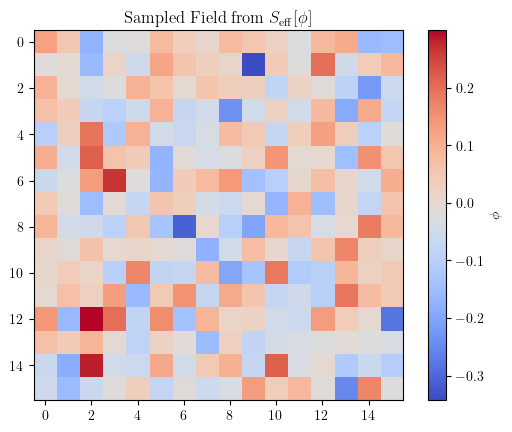

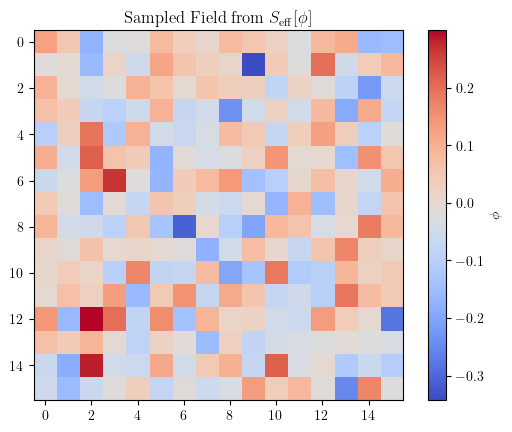

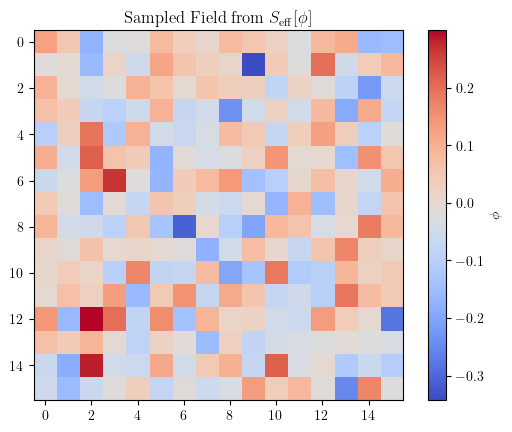

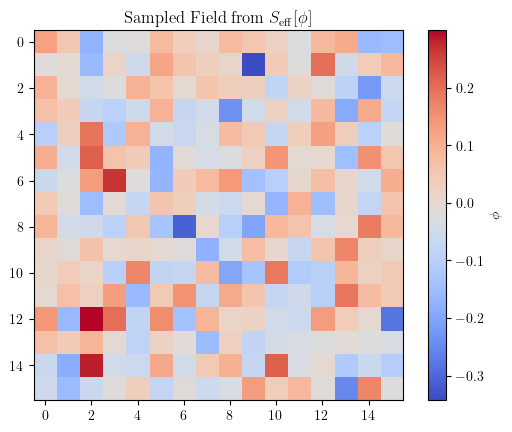

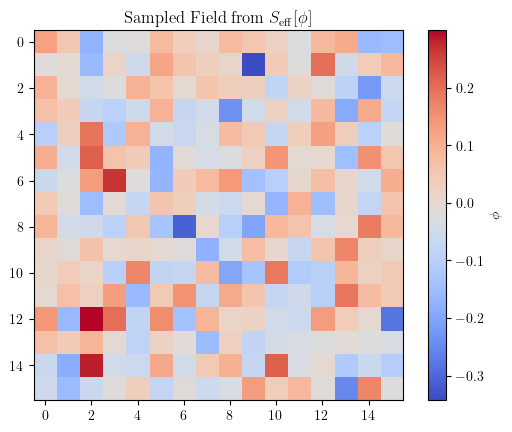

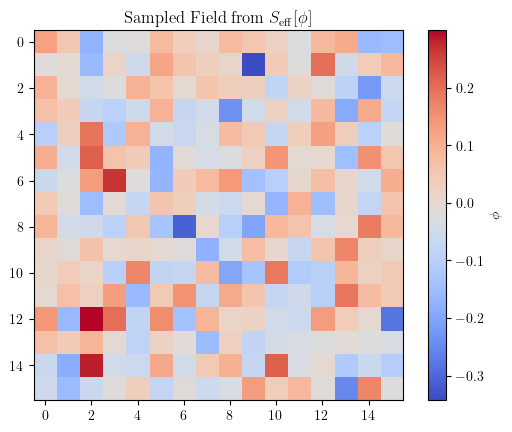

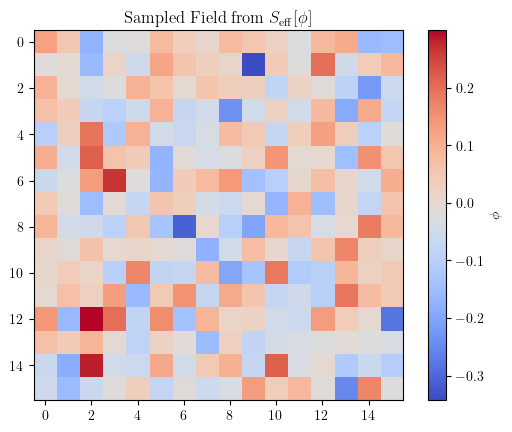

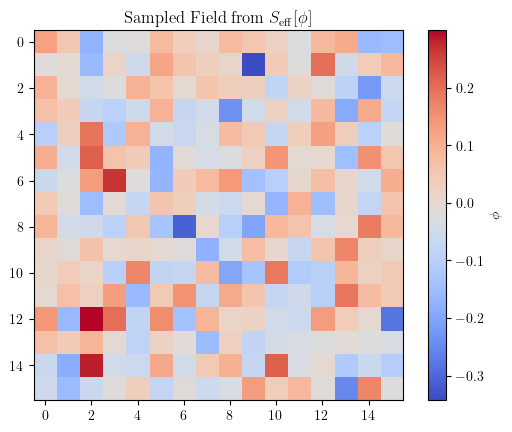

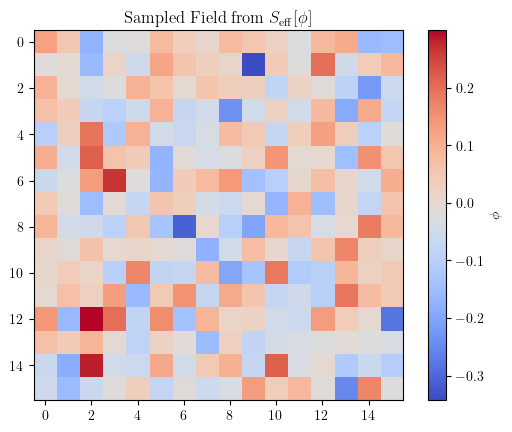

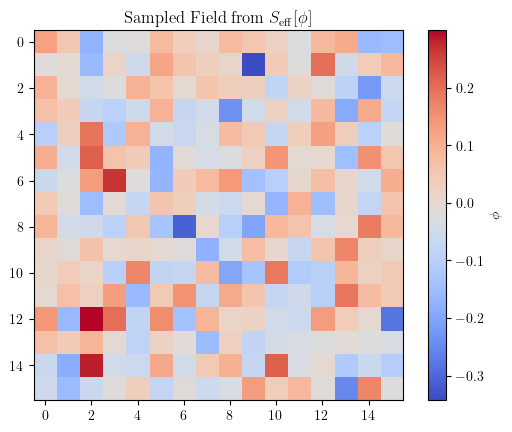

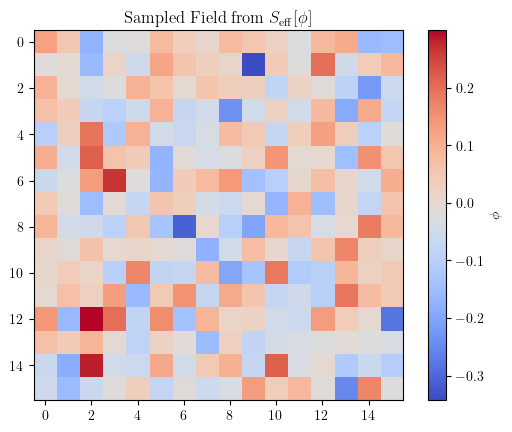

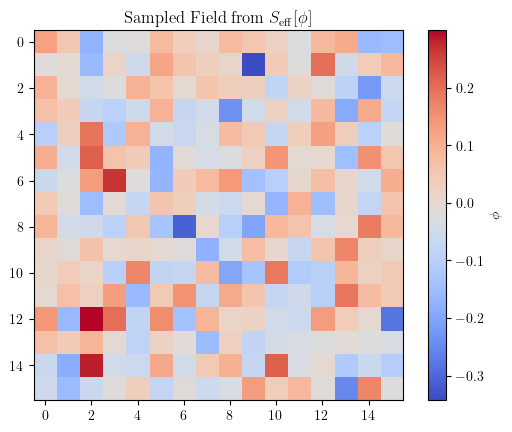

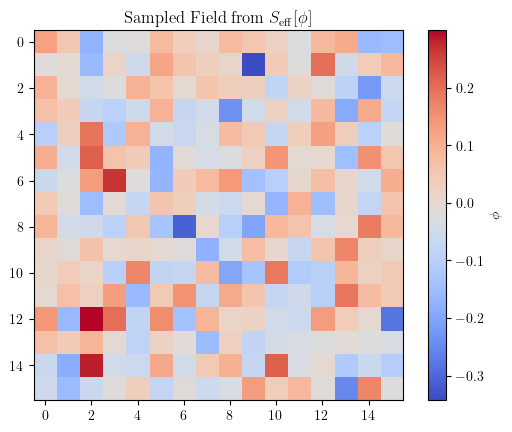

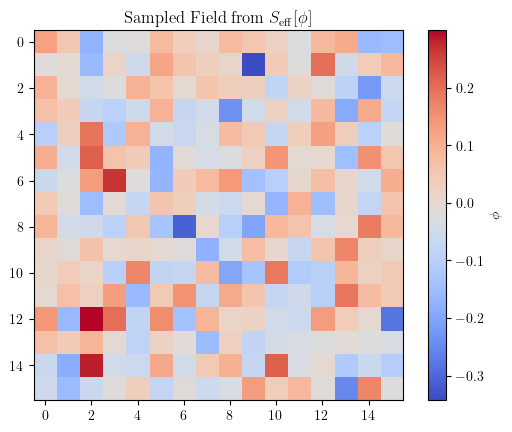

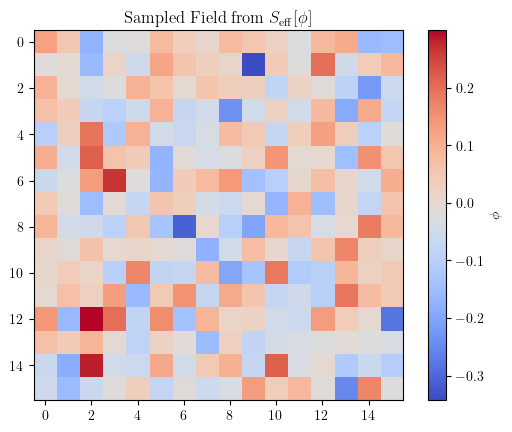

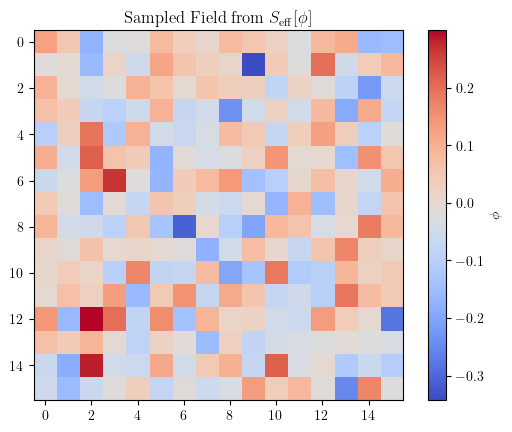

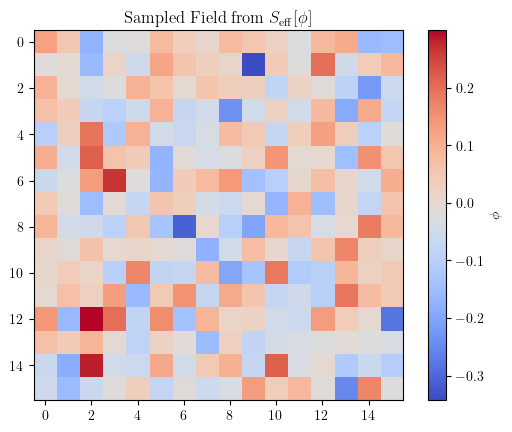

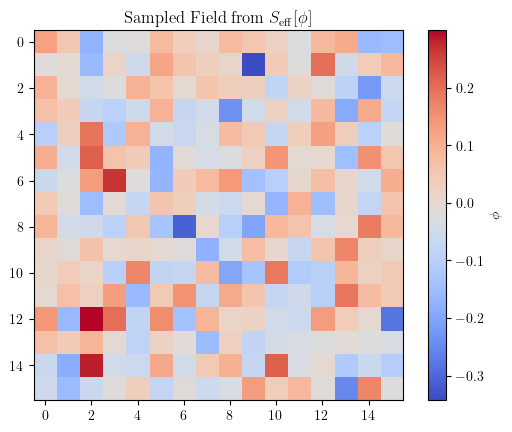

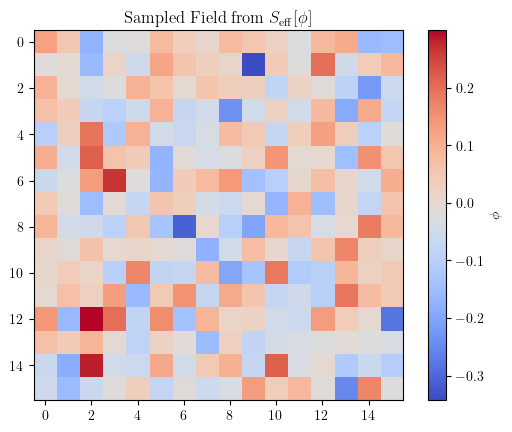

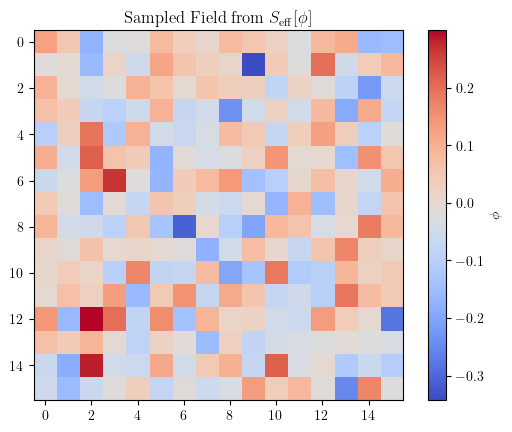

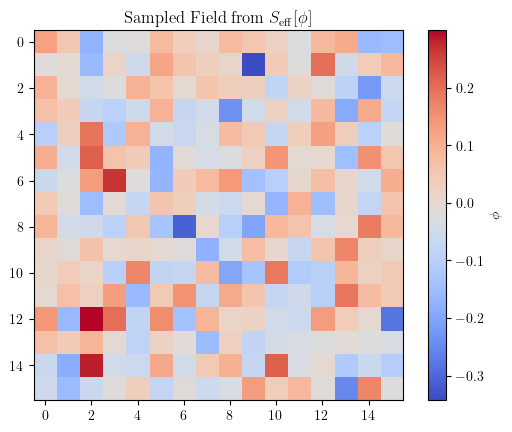

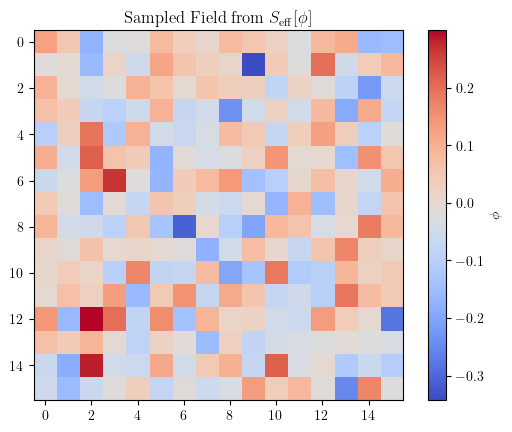

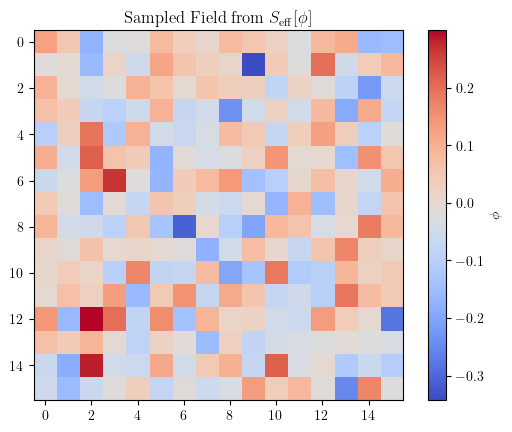

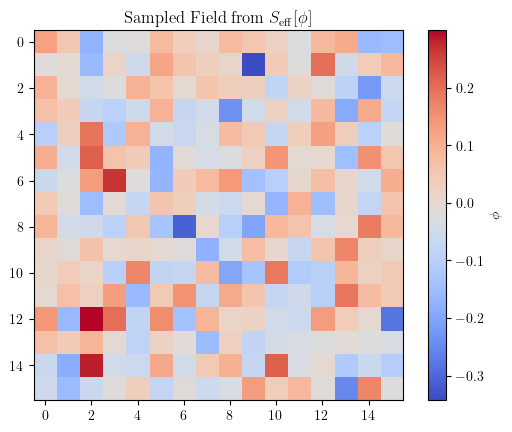

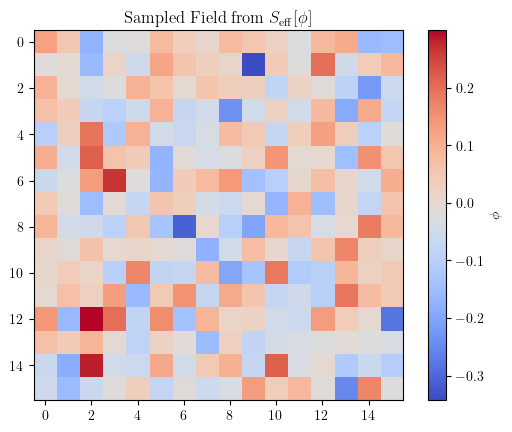

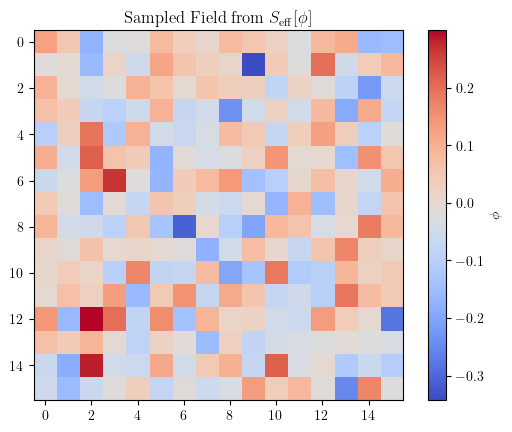

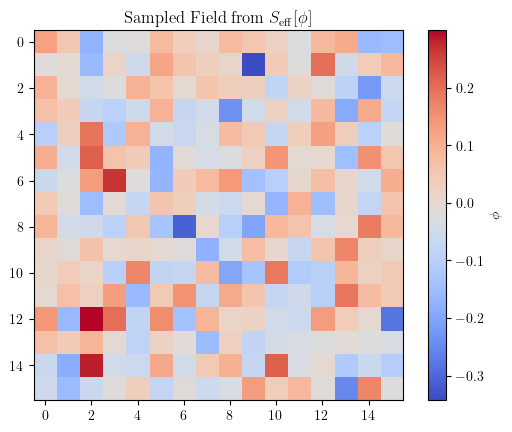

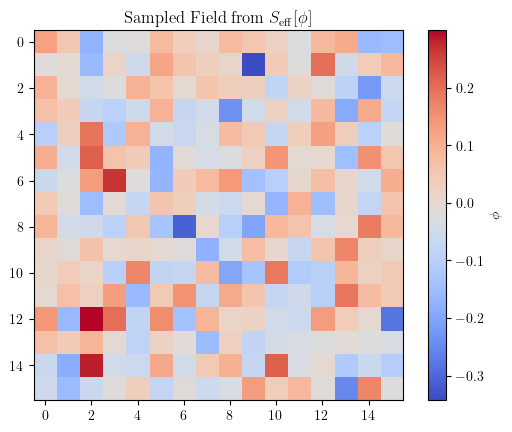

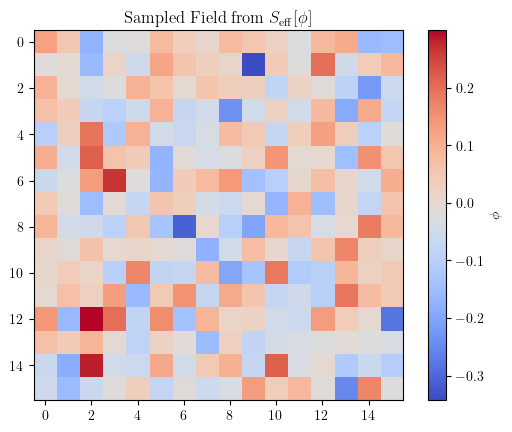

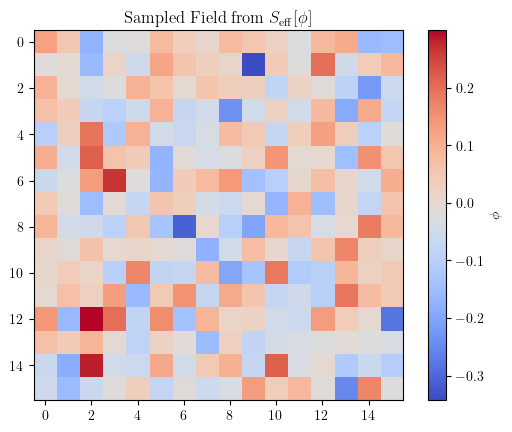

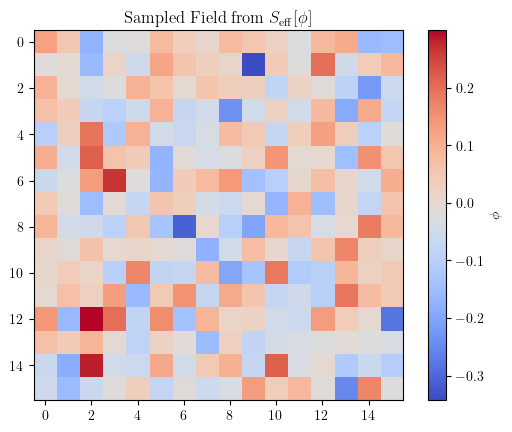

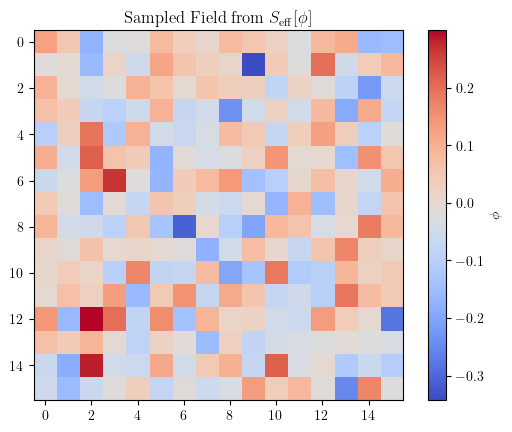

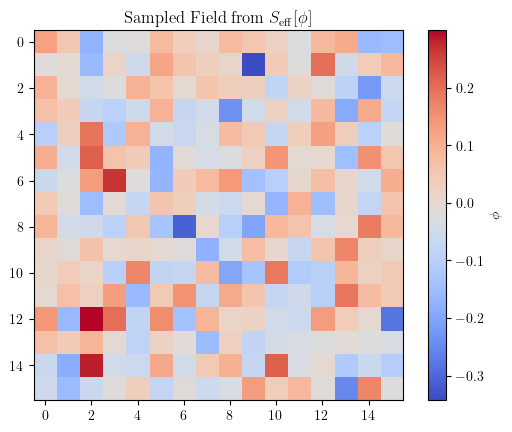

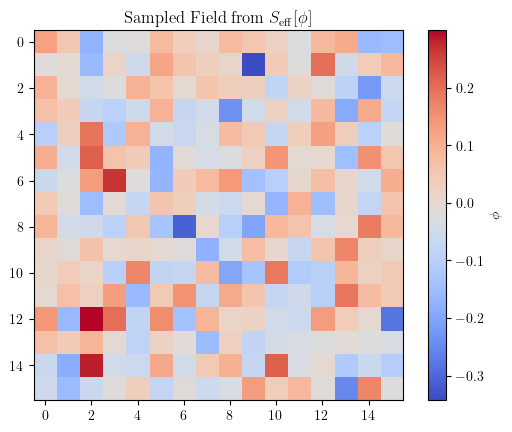

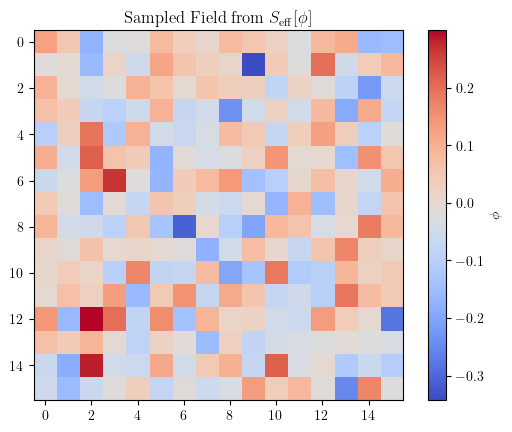

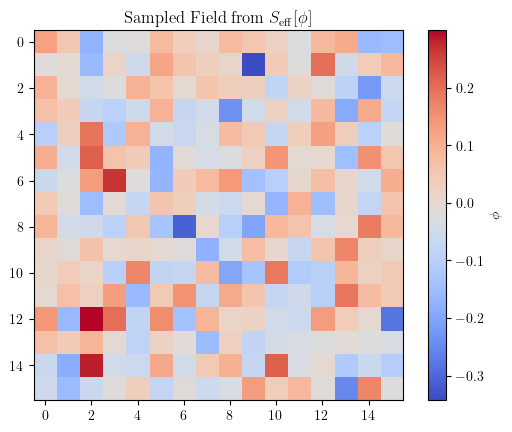

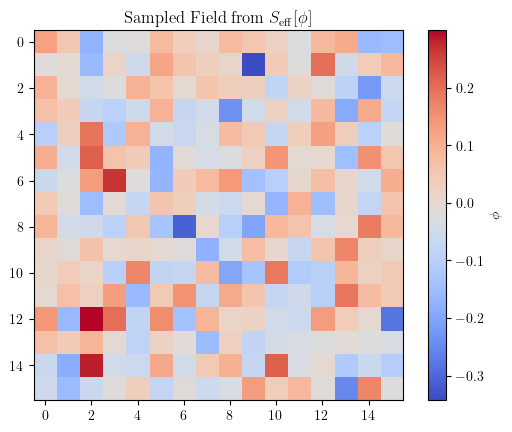

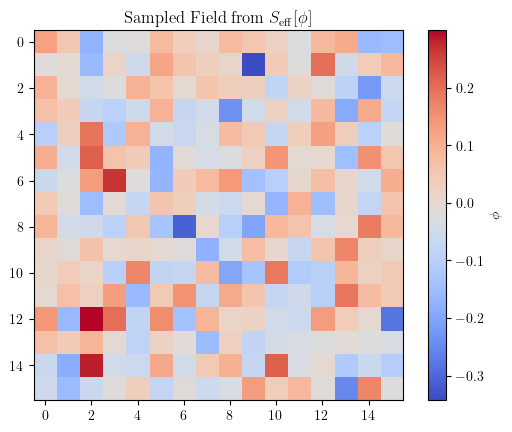

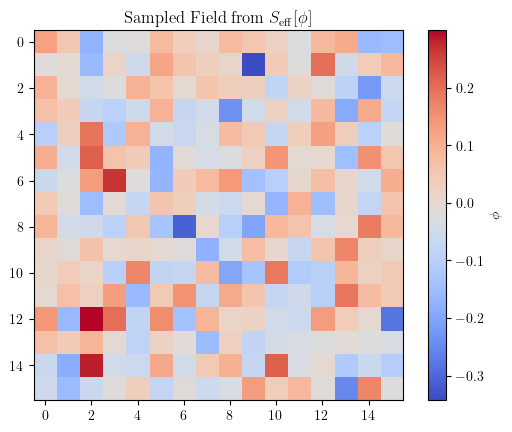

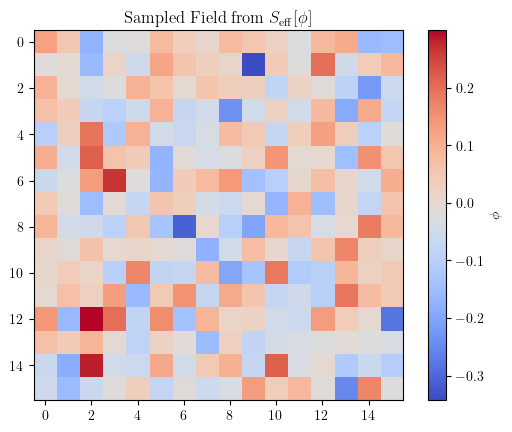

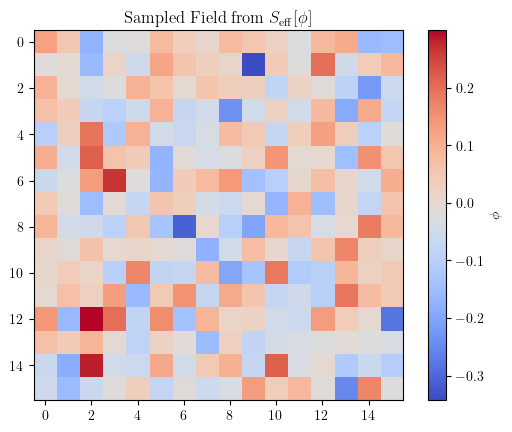

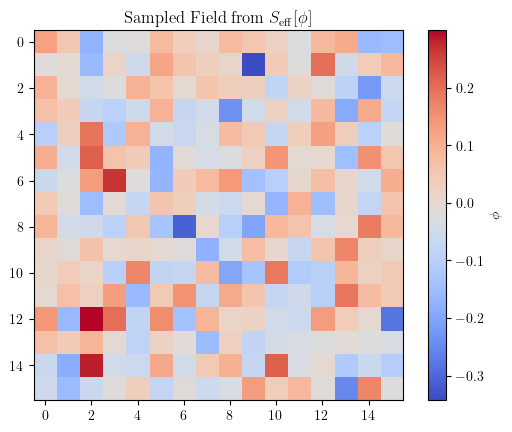

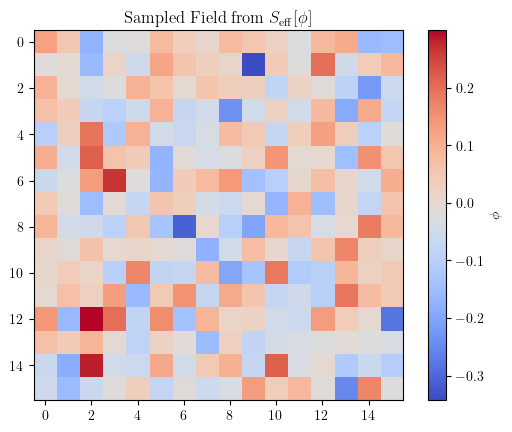

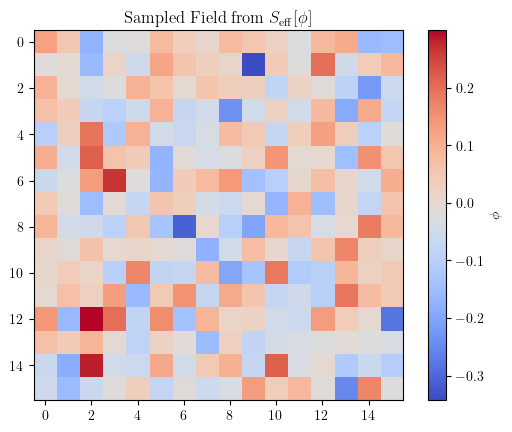

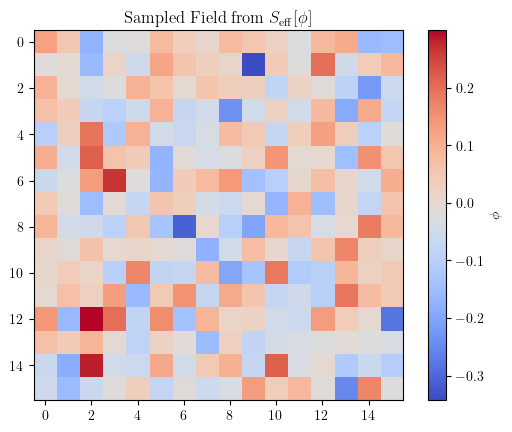

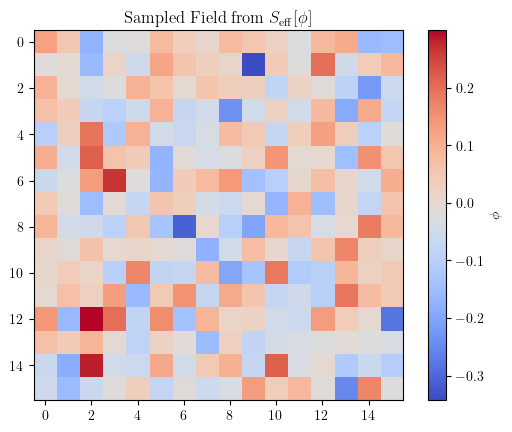

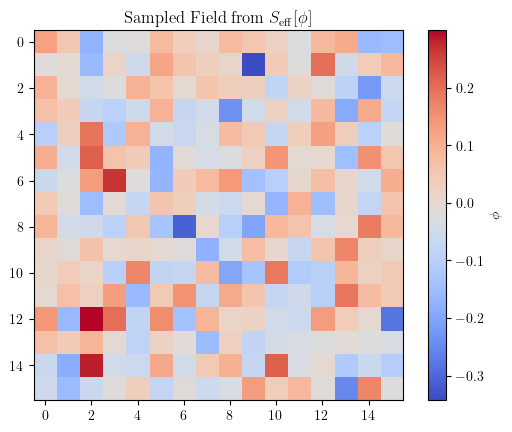

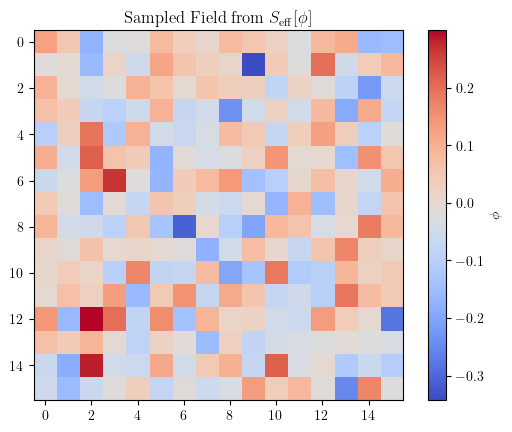

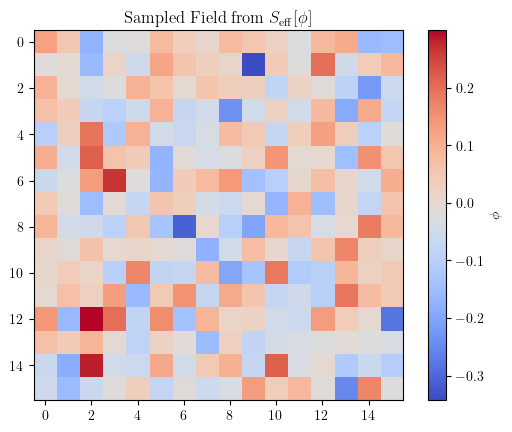

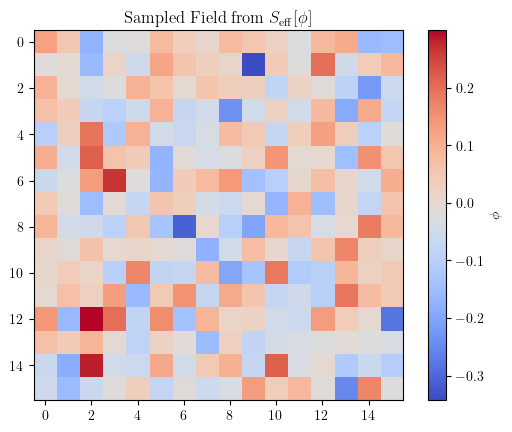

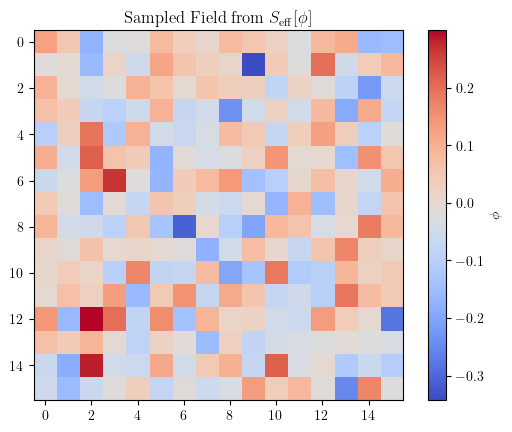

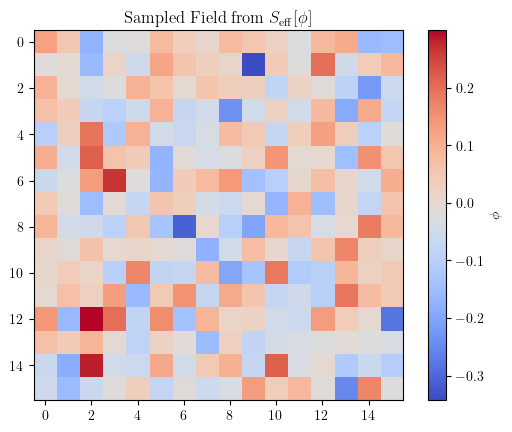

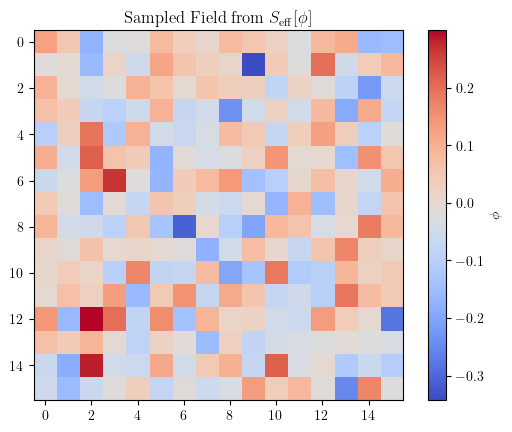

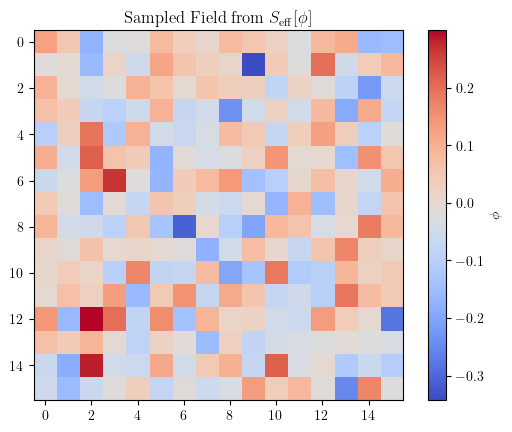

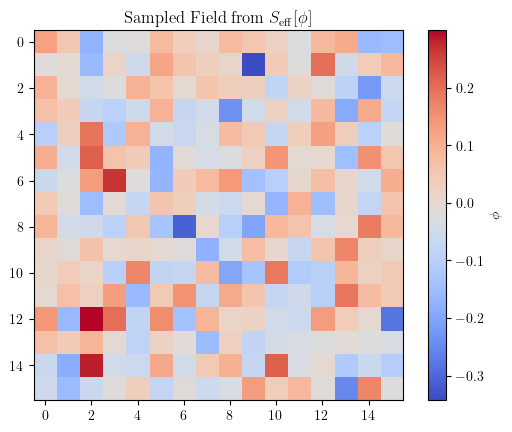

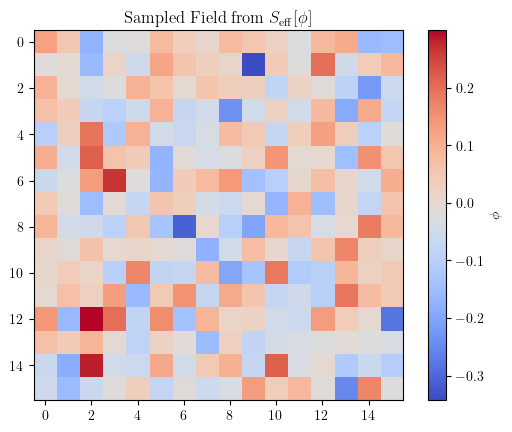

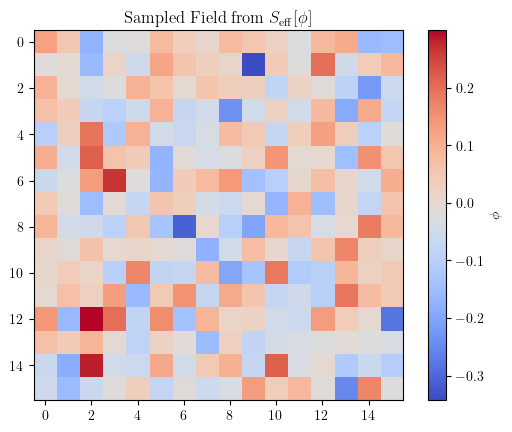

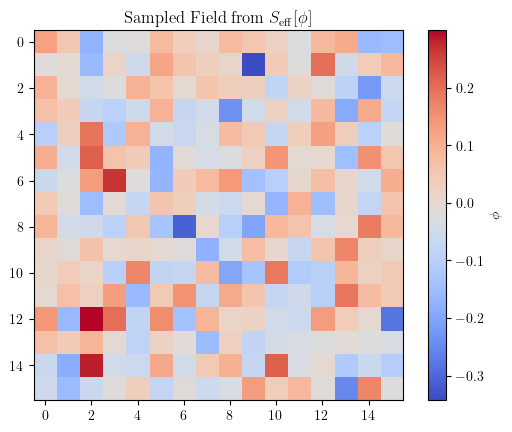

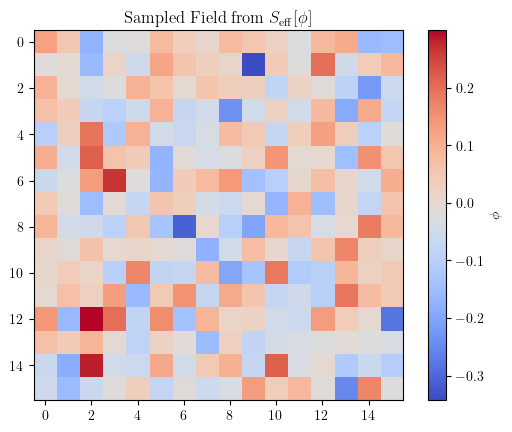

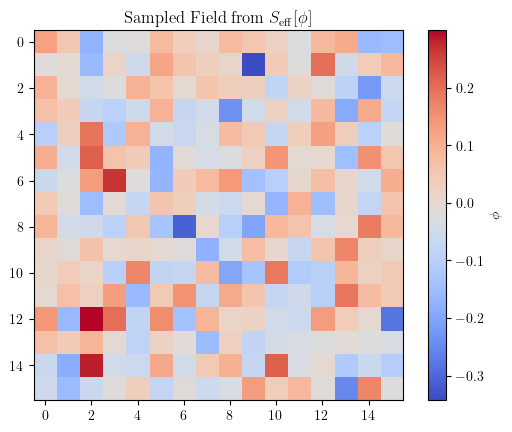

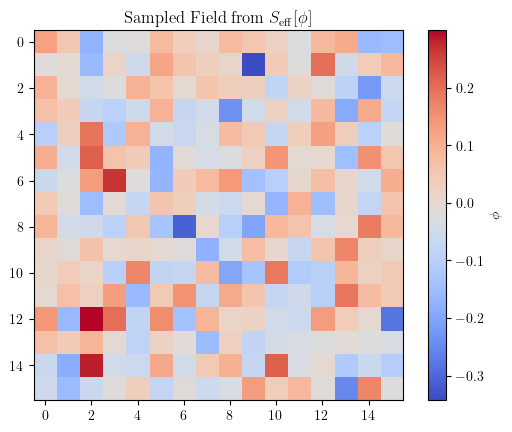

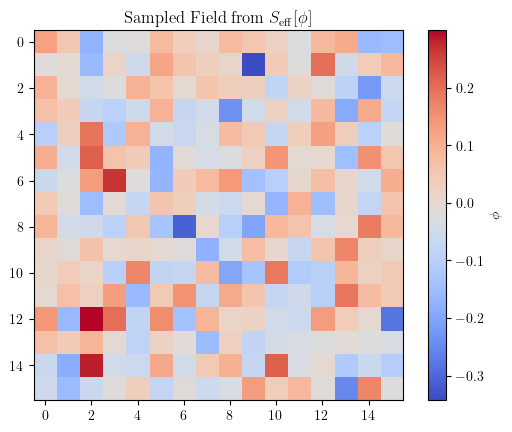

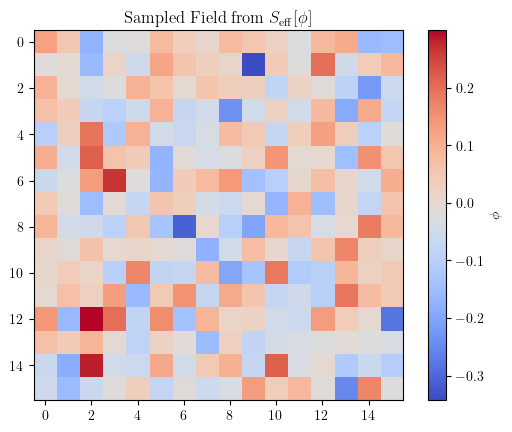

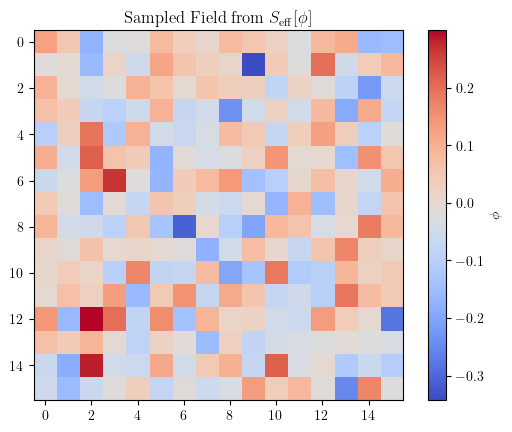

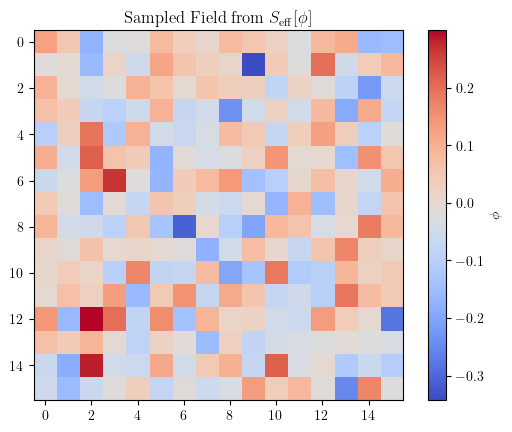

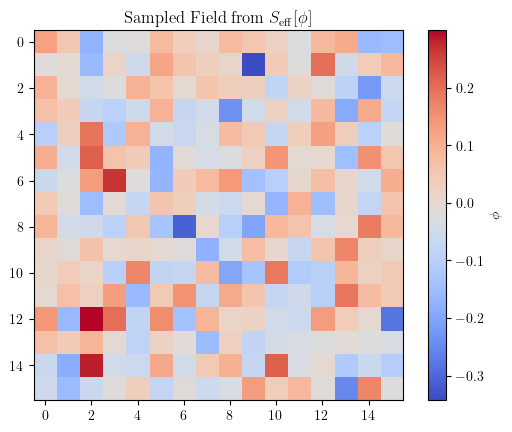

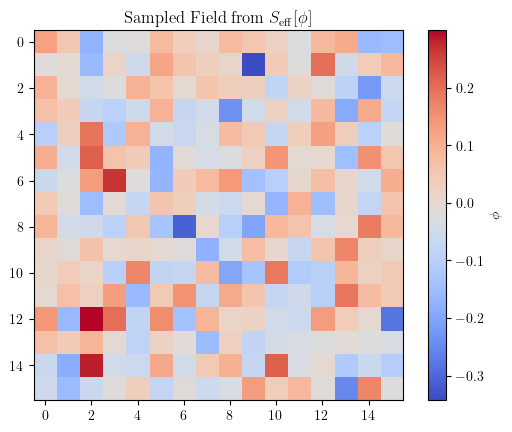

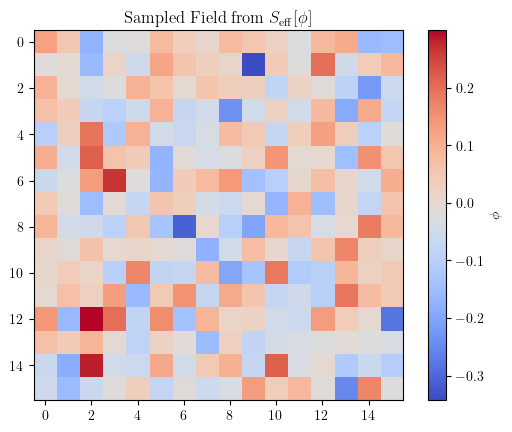

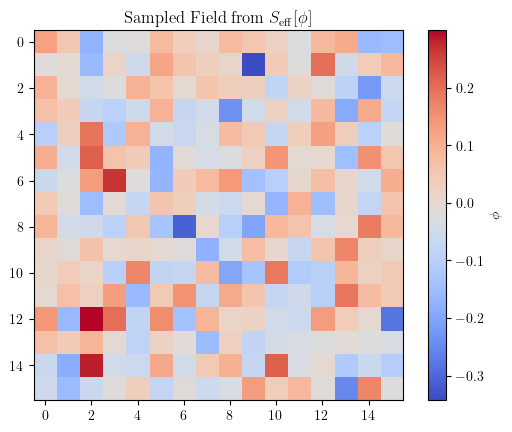

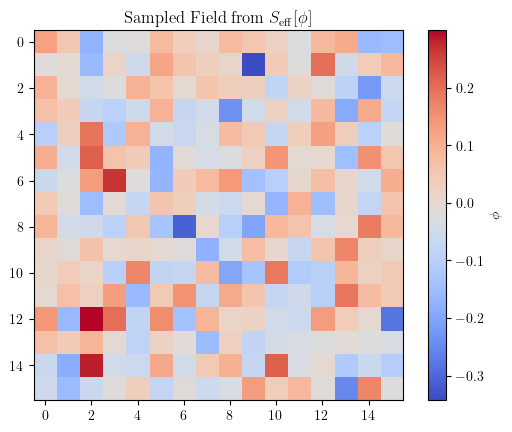

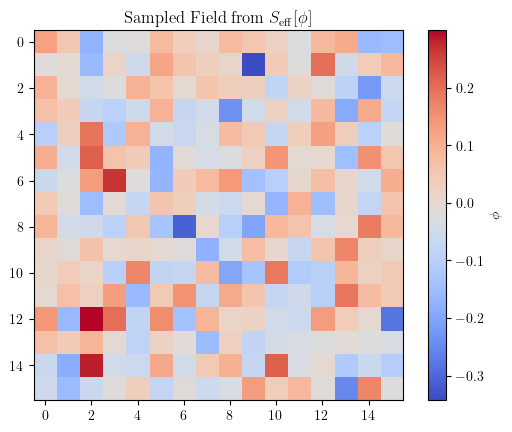

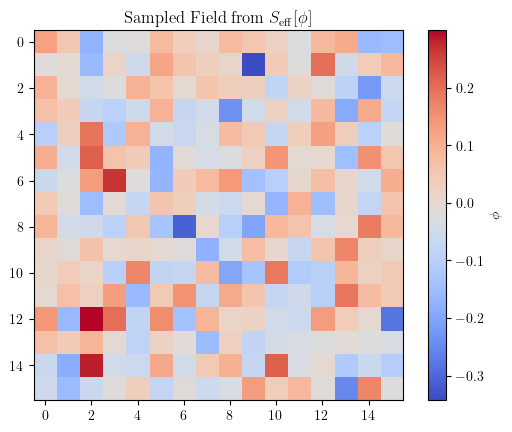

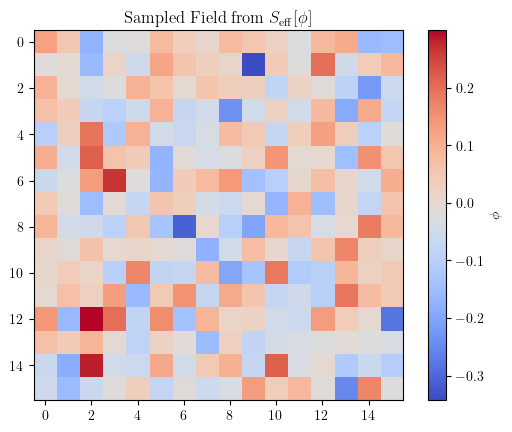

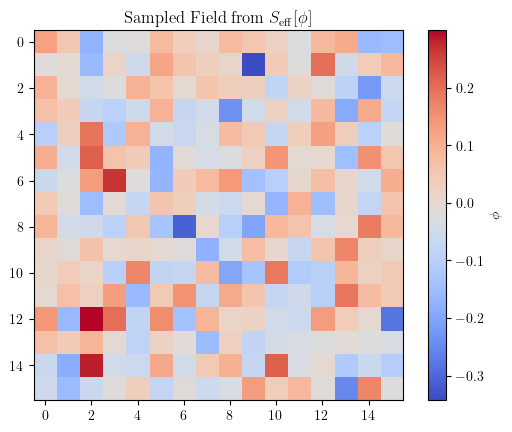

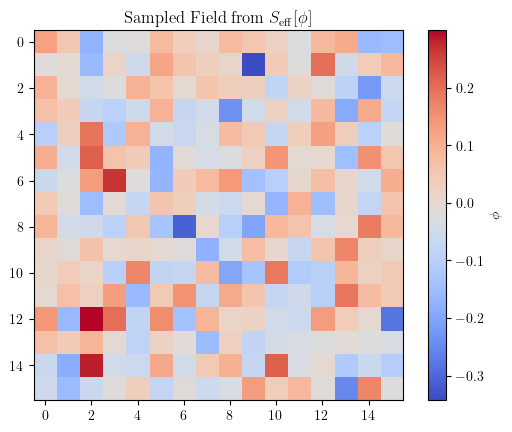

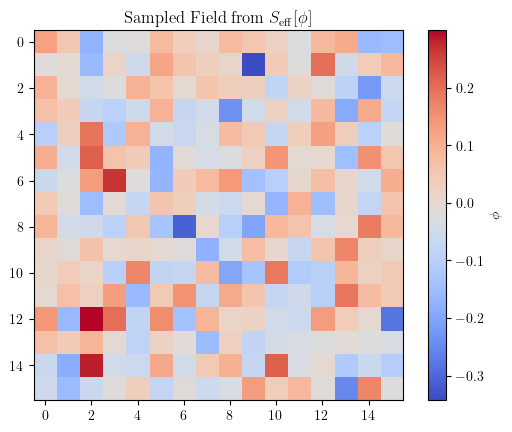

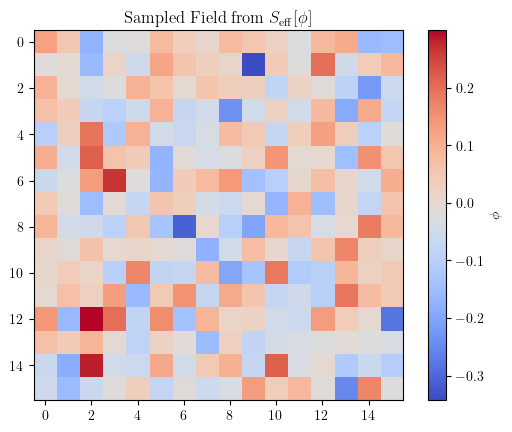

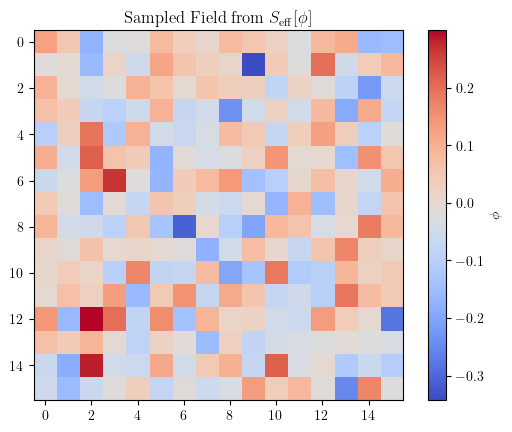

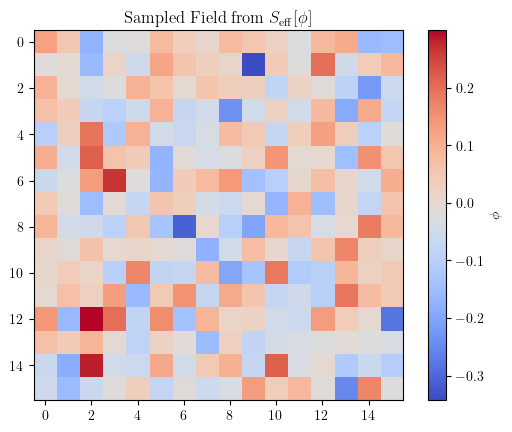

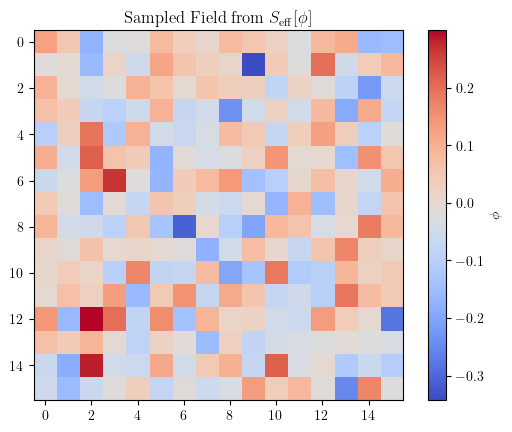

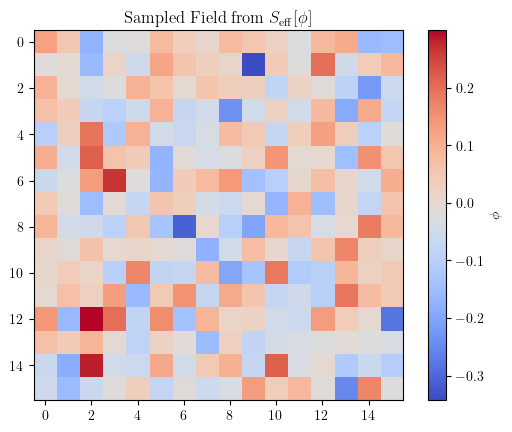

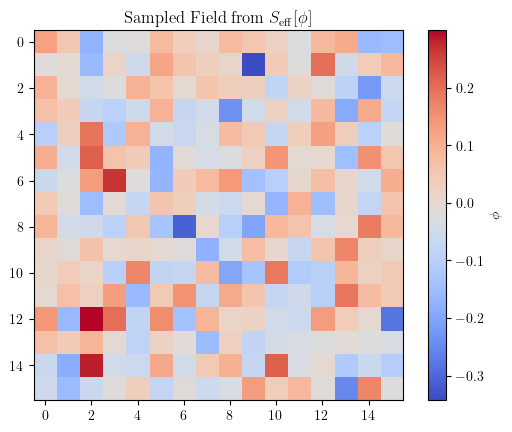

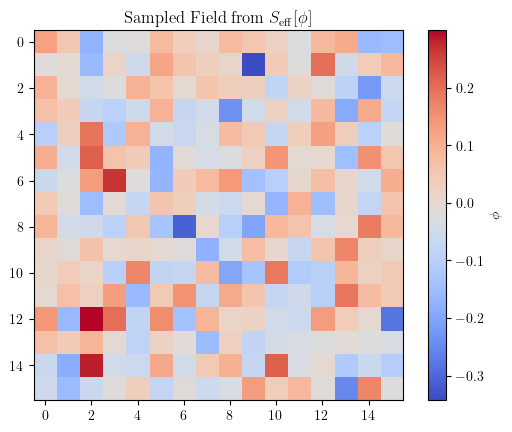

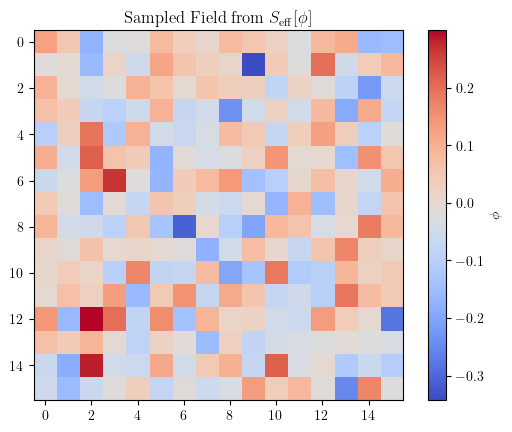

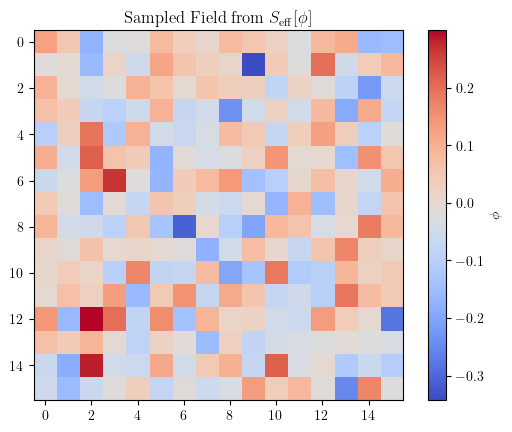

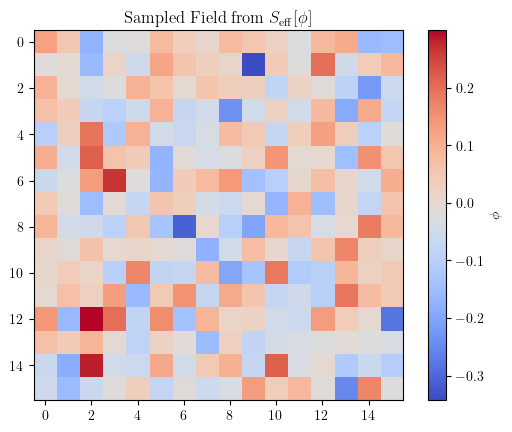

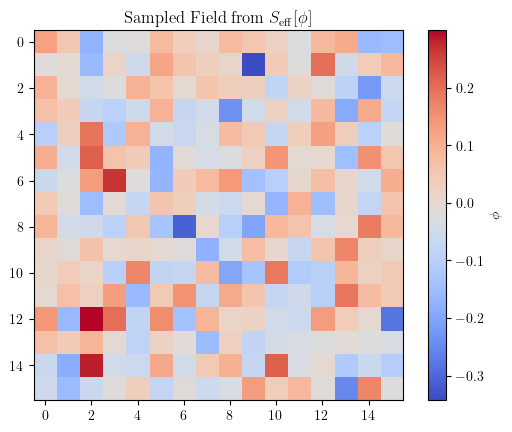

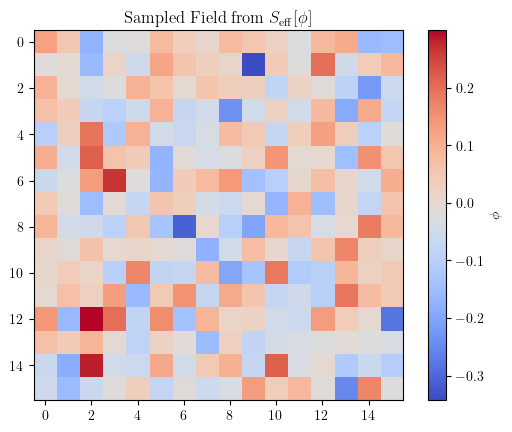

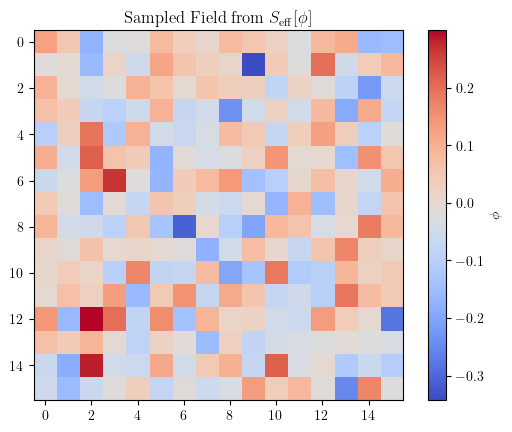

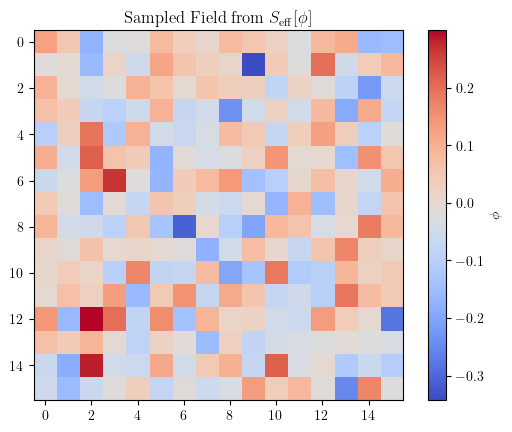

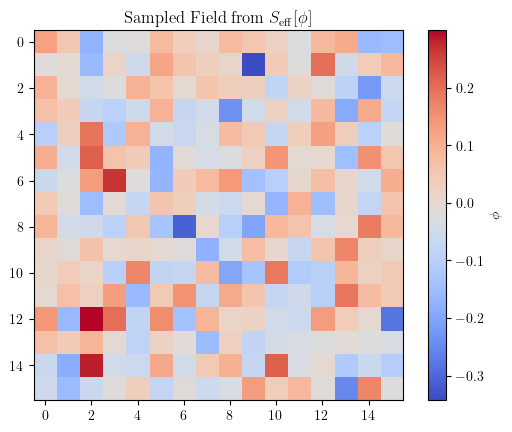

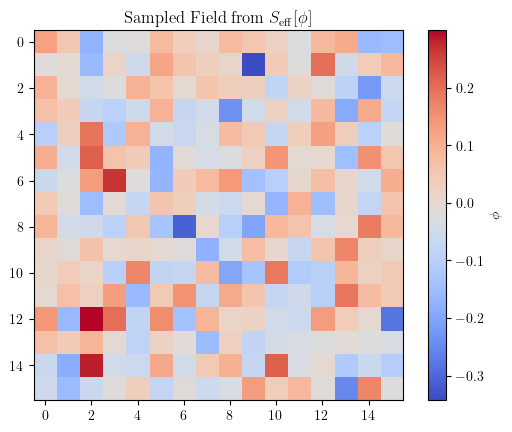

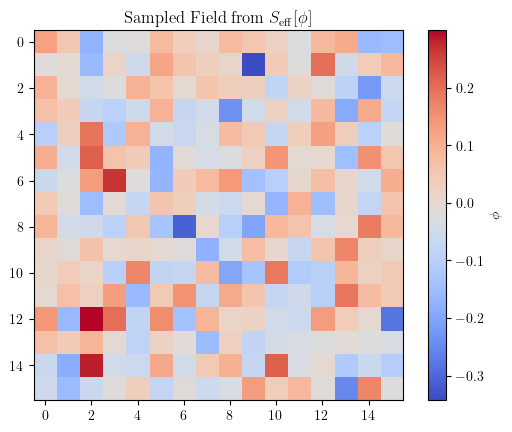

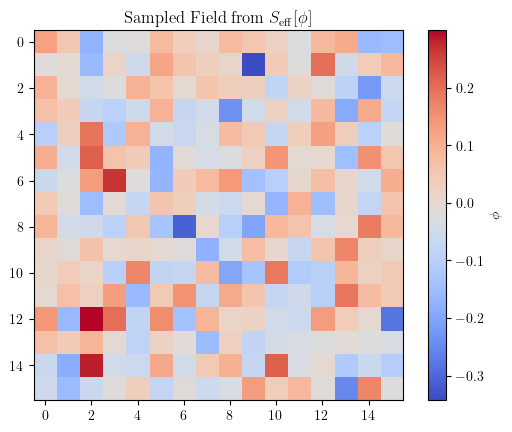

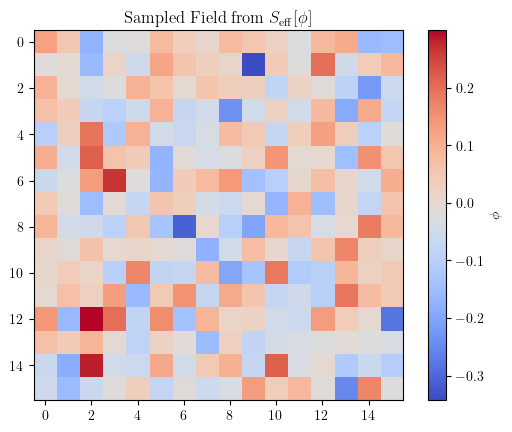

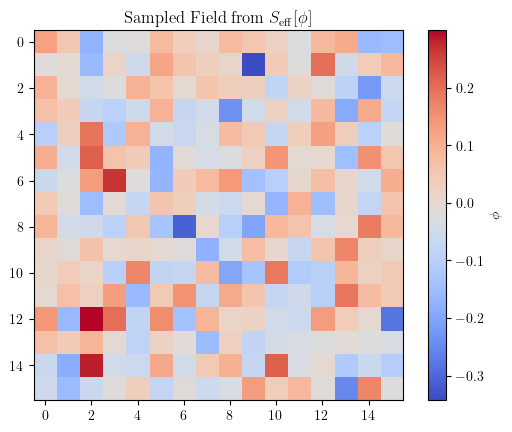

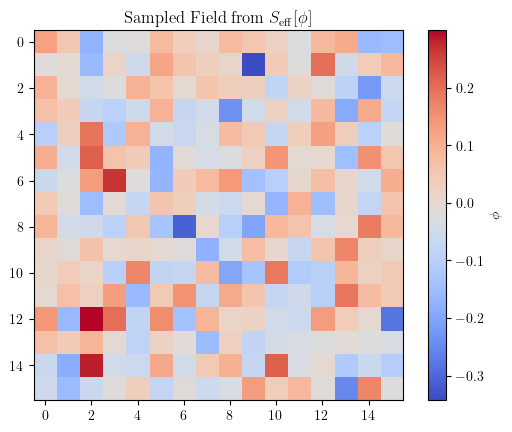

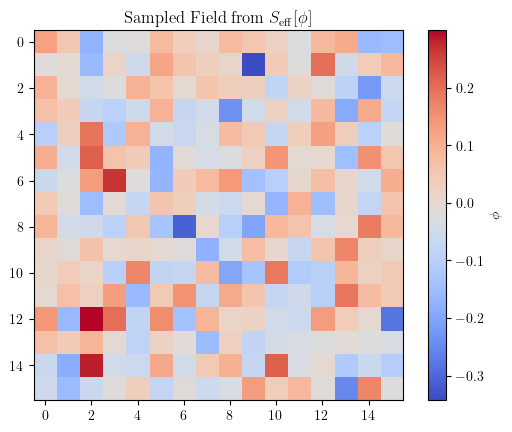

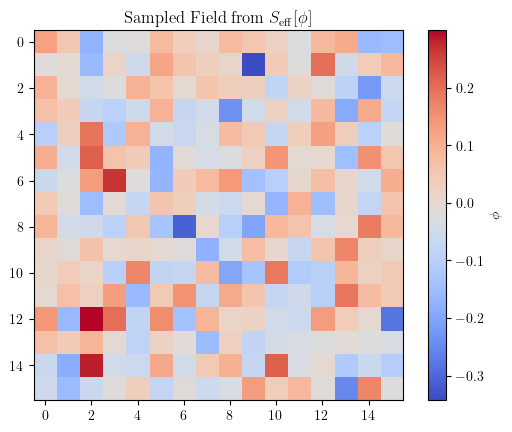

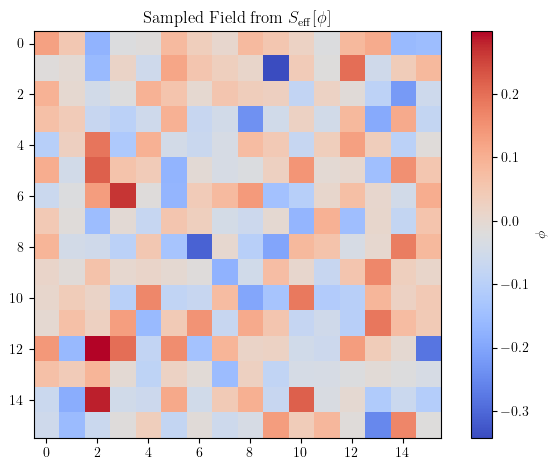

In [85]:
# --- 6. Sample from the effective action in 2D via Metropolis
size = 16
n_sweeps = 10000
beta = 10.0  # inverse temperature
step_size = 0.1

# Initialize phi field
phi = np.random.normal(0, 0.1, size=(size, size))

# Energy function (lattice gradient + potential)
def local_action(phi_field, i, j):
    phi_val = phi_field[i, j]
    pot = p(phi_val)
    neighbors = (
        phi_field[(i + 1) % size, j] +
        phi_field[(i - 1) % size, j] +
        phi_field[i, (j + 1) % size] +
        phi_field[i, (j - 1) % size]
    )
    grad_term = 0.5 * (4 * phi_val**2 - 2 * phi_val * neighbors)
    return beta * (grad_term + pot)

# Metropolis–Hastings updates
for sweep in range(n_sweeps):
    for i in range(size):
        for j in range(size):
            old = phi[i, j]
            new = old + np.random.normal(0, step_size)
            dS = (
                local_action(phi, i, j)
                - p(old)
                - 0.5 * (4 * old**2 - 2 * old * (
                    phi[(i + 1) % size, j] +
                    phi[(i - 1) % size, j] +
                    phi[i, (j + 1) % size] +
                    phi[i, (j - 1) % size]
                ))
            )
            if np.random.rand() < np.exp(-dS):
                phi[i, j] = new
    if sweep % 100 == 0:
        plt.imshow(phi, cmap='coolwarm', interpolation='nearest')
        plt.colorbar(label=r'$\phi$')
        plt.title('Sampled Field from $S_{\mathrm{eff}}[\phi]$')
        plt.show()

# --- 7. Plot sampled field configuration
plt.imshow(phi, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label=r'$\phi$')
plt.title('Sampled Field from $S_{\mathrm{eff}}[\phi]$')
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from IPython.display import display, clear_output

# --- Parameters ---
size = 16
n_steps_per_frame = 10
step_size = 0.1
np.random.seed(0)

def p(phi):
    return phi**2 + phi**4 + phi**6  # Example potential function

# --- Initial field ---
phi = np.random.normal(0, 0.1, size=(size, size))

# --- Action parts ---
def local_action(phi_field, i, j, a2, a4, beta):
    phi_val = phi_field[i, j]
    pot = a2 * phi_val**2 + a4 * phi_val**4
    neighbors = (
        phi_field[(i + 1) % size, j] +
        phi_field[(i - 1) % size, j] +
        phi_field[i, (j + 1) % size] +
        phi_field[i, (j - 1) % size]
    )
    grad_term = 0.5 * (4 * phi_val**2 - 2 * phi_val * neighbors)
    return beta * (grad_term + pot)

# --- Interactive Metropolis sampling ---
def run_simulation(a2, a4, beta):
    global phi
    fig, ax = plt.subplots(figsize=(5, 5))
    img = ax.imshow(phi, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(img, ax=ax)
    plt.title(f'Metropolis sampling {a2}, {a4}, {beta}')

    for step in range(n_steps_per_frame):
        for i in range(size):
            for j in range(size):
                old = phi[i, j]
                new = old + np.random.normal(0, step_size)
                dS_old = local_action(phi, i, j, a2, a4, beta)
                # Temporarily change value
                phi[i, j] = new
                dS_new = local_action(phi, i, j, a2, a4, beta)
                dS = dS_new - dS_old
                if np.random.rand() >= np.exp(-dS):
                    phi[i, j] = old  # revert

    img.set_data(phi)
    clear_output(wait=True)
    display(fig)
    plt.close(fig)

# --- Live sliders and animation loop ---
@interact(
    a2=FloatSlider(value=1.0, min=-2.0, max=2.0, step=0.05, description='a₂'),
    a4=FloatSlider(value=1.0, min=0.0, max=5.0, step=0.05, description='a₄'),
    beta=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='β'),
    steps=IntSlider(value=100, min=1, max=1000, step=50, description='Frames')
)
def interactive_run(a2, a4, beta, steps):
    for _ in range(steps):
        run_simulation(a2, a4, beta)


interactive(children=(FloatSlider(value=1.0, description='a₂', max=2.0, min=-2.0, step=0.05), FloatSlider(valu…